# Matrix completion and recommender systems

[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.
 
This data set consists of:
- 100000 ratings (1-5) from 943 users on 1682 movies. 
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly              ordered. This is a tab separated list of 

```
user id | item id | rating | timestamp
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

Read the dataset from the `movielens.csv` file.

In [2]:
dataset = pd.read_csv('../data/movielens.csv', sep = '\t', header = None)
dataset.describe()

,0,1,2,3
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


How many movies? How many people? How many ratings?

In [3]:
rows = np.array(dataset[0]) - 1
cols = np.array(dataset[1]) - 1
vals = np.array(dataset[2])

n = rows.max() + 1
p = cols.max() + 1
d = len(rows)

print('%d users' % n)
print('%d movies' % p)
print('%d ratings' % d)

943 users
1682 movies
100000 ratings


Shuffle the data (see the function [`np.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html)).

In [4]:
idx = np.arange(d)
np.random.seed(1) # for reproducibility
np.random.shuffle(idx)
rows = rows[idx]
cols = cols[idx]
vals = vals[idx]

Split the dataset into a subset of 80000 training ratings and 20000 testing ratings.

In [5]:
n_train_samples = 80000

rows_train = rows[:n_train_samples]
cols_train = cols[:n_train_samples]
vals_train = vals[:n_train_samples]

rows_test  = rows[n_train_samples:]
cols_test  = cols[n_train_samples:]
vals_test  = vals[n_train_samples:]

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $i$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:
$$
X_{i,j} = 
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$

In [6]:
X_full = csr_matrix((vals_train, (rows_train, cols_train)), shape=(n, p)).toarray()
X_full

array([[0, 3, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

## Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:
$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$
where $N_i = card(j : (i,j) \in \Omega)$.

Then compute the RMSE (root mean square error):
$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$
and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):
$$
\rho = 
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}} 
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}} 
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}} 
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$
where
$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} 
       r_{ij} 
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} 
       r^{\text{pred}}_{ij} 
\end{split}
$$

In [7]:
average_ratings = np.array([np.mean(vals_train[rows_train == i]) for i in range(n)])
vals_test_trivial = average_ratings[rows_test]
error_trivial = vals_test - vals_test_trivial

RMSE_trivial = np.sqrt(np.mean(error_trivial**2))
rho_trivial = pearsonr(vals_test, vals_test_trivial)[0]

print('RMSE = %f' % RMSE_trivial)
print('rho = %f' % rho_trivial)

RMSE = 1.043231
rho = 0.383526


# Singular value truncation (SVT) based recommender system

Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.

Try to calibrate the threshold to get better results.

In [8]:
n_max_iter = 100
threshold = 120.0
tolerance = 1e-6

RMSE_SVT_history = []
pearson_SVT_history = []

X_hat = X_full.copy()
for k in range(n_max_iter):
  X_hat_old = X_hat.copy()
  U,s,VT = np.linalg.svd(X_hat, full_matrices = False)
  s[s < threshold] = 0
  X_hat = U @ np.diag(s) @ VT
  X_hat[rows_train, cols_train] = vals_train
  increment = np.linalg.norm(X_hat - X_hat_old)

  vals_test_SVT = X_hat[rows_test, cols_test]
  RMSE_SVT = np.sqrt(np.mean((vals_test - vals_test_SVT)**2))
  pearson_SVT = pearsonr(vals_test, vals_test_SVT)[0]

  RMSE_SVT_history.append(RMSE_SVT)
  pearson_SVT_history.append(pearson_SVT)

  print('======= iteration %d (increment %1.2e)' % (k, increment))
  print('RMSE = %f' % RMSE_SVT)
  print('rho = %f' % pearson_SVT)

  if increment < tolerance:
    break

======= iteration 0 (increment 4.28e+02)
RMSE = 2.642192
rho = 0.302772
======= iteration 1 (increment 2.61e+02)
RMSE = 2.199961
rho = 0.330674
======= iteration 2 (increment 1.88e+02)
RMSE = 1.950025
rho = 0.352464
======= iteration 3 (increment 1.47e+02)
RMSE = 1.785920
rho = 0.369969
======= iteration 4 (increment 1.21e+02)
RMSE = 1.668711
rho = 0.384398
======= iteration 5 (increment 1.02e+02)
RMSE = 1.580392
rho = 0.396556
======= iteration 6 (increment 8.88e+01)
RMSE = 1.511300
rho = 0.406989
======= iteration 7 (increment 7.83e+01)
RMSE = 1.455714
rho = 0.416075
======= iteration 8 (increment 6.99e+01)
RMSE = 1.410006
rho = 0.424081
======= iteration 9 (increment 6.32e+01)
RMSE = 1.371751
rho = 0.431207
======= iteration 10 (increment 5.76e+01)
RMSE = 1.339266
rho = 0.437602
======= iteration 11 (increment 5.28e+01)
RMSE = 1.311342
rho = 0.443379
======= iteration 12 (increment 4.88e+01)
RMSE = 1.287087
rho = 0.448631
======= iteration 13 (increment 4.54e+01)
RMSE = 1.265827
rho

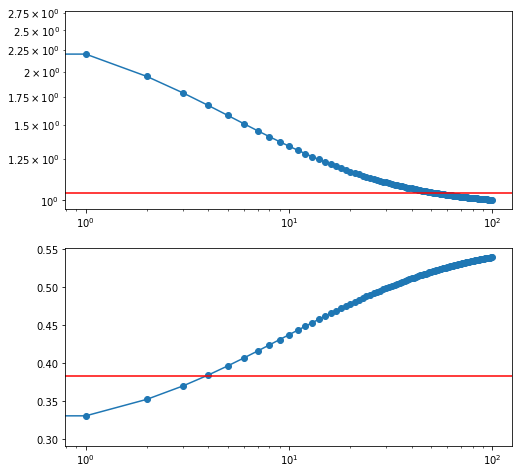

In [9]:
fig, axs = plt.subplots(2,1,figsize = (8,8))
axs[0].loglog(RMSE_SVT_history, 'o-')
axs[0].axhline(RMSE_trivial, color = 'red')
axs[1].semilogx(pearson_SVT_history, 'o-')
axs[1].axhline(rho_trivial, color = 'red')